In [239]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import astropy.io.fits as fits

    
def spatialCoords(l,b,D, origin='galcenter'):
    '''
    converts a set of galactic coordinates to 3-D cartesian
    coordinates centered at the sun or the galactic center.
    
    Parameters:
       origin: 'sun' or 'galcenter'
       l, b: galactic coordinates in degrees
       D: distance from the sun to each object, in parsec
    '''
    cl=np.cos(l*np.pi/180)
    sl=np.sin(l*np.pi/180)
    cb=np.cos(b*np.pi/180)
    sb=np.sin(b*np.pi/180)
    Rsun=8340 #distance from the sun to the GC 
    zsun=27 #the height scale of the sun is set to 27pc according to Chen et al. 2003 
    if origin=='galcenter':
        x=Rsun-D*cl*cb
        z=zsun+D*sb
    else:
        if origin=='galcenterz0':
            x=Rsun-D*cl*cb
            z=0+D*sb
        else:
            x=D*cl*cb
            z=D*sb
    y=-D*sl*cb
    
    return x,y,z

def VrpmUVW(ra, dec, Vr, pmra, pmdec, D, Vrerr, pmraerr, pmdecerr, Derr, velsun):
    '''
    Vpm2UVW converts radial velocities and proper motions to 3D velocities.
    Parameters:
    Vr: radial velocity from observation
    pmra, pmdec: proper motion in equatorial coordinates
    ra,dec:equatorial coordinates
    D: distance to the Sun in pc.
    Return:
    U, V, W: 3D velocity components with respect to LSR
    REF:Johnson & Soderblom(1987)
    '''
    #velsun = [10,5.25,7.17]
    #velsun = [9.58,10.52,7.01]
#    velsun = [9.58,20,7.01]
#    T=[[-0.06699, -0.87276, -0.48354]
#       [+0.49273, -0.45035, +0.74458] 
#       [-0.86760, -0.18837, +0.46020]]
    k = 4.74057 
    ra0 = ra*np.pi/180.0
    dec0 = dec*np.pi/180.0
    cra = np.cos(ra0)
    sra = np.sin(ra0)
    cdec = np.cos(dec0)
    sdec = np.sin(dec0)
    
    
    B11=-0.063491*cra*cdec -0.86554 *sra*cdec -0.496799*sdec
    B12= 0.063491*sra       -0.86554 *cra       +0
    B13= 0.063491*cra*sdec +0.86554 *sra*sdec -0.496799*cdec
    
    B21= 0.493076*cra*cdec -0.460007*sra*cdec +0.738424*sdec
    B22=-0.493076*sra       -0.460007*cra       +0
    B23=-0.493076*cra*sdec +0.460007*sra*sdec +0.738424*cdec
    
    B31=-0.867666*cra*cdec -0.198076*sra*cdec +0.455984*sdec
    B32= 0.867666*sra       -0.198076*cra       +0
    B33= 0.867666*cra*sdec +0.198076*sra*sdec +0.455984*cdec
    
    U = velsun[0]+Vr*B11+k*pmra*D*B12/1000.0+k*pmdec*D*B13/1000.0
    V = velsun[1]+Vr*B21+k*pmra*D*B22/1000.0+k*pmdec*D*B23/1000.0
    W = velsun[2]+Vr*B31+k*pmra*D*B32/1000.0+k*pmdec*D*B33/1000.0
    Uerr = np.sqrt(B11**2*Vrerr**2+\
        (k*B12/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B13/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
    Verr=np.sqrt(B21**2*Vrerr**2+\
        (k*B22/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B23/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
    Werr=np.sqrt(B31**2*Vrerr**2+\
        (k*B32/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B33/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
        
    return U,V,W,Uerr,Verr,Werr



def velocitycart2cylindrical(U,V,W,l,b,dist,Uerr,Verr,Werr,disterr,Vlsr,Rsun):
    '''
        Convert the UVW to velocity compoennts in cylindrical coordinates
        Parameters:
        U: velocity in X, in km/s
        V: velocity in Y, in km/s
        W: velocity in Y, in km/s
        l,b: Galactic coordniates, in degrees
        dist: distance in pc
        Vlsr circular speed at LSR
        Rsun: distance from the Galactic center to the Sun;\
    '''

    cbsl=np.cos(deg2rad(b))*np.sin(deg2rad(l))
    cbcl=np.cos(deg2rad(b))*np.cos(deg2rad(l))
    tanphi=(dist*cbsl/(Rsun-dist*cbcl))
    tanphierr2=disterr**2*(cbsl**2*Rsun**2)/(Rsun-dist*cbcl)**4
    phi=np.arctan(tanphi)
    phierr2=tanphierr2/(1+tanphi**2)**2
    VR=-np.cos(phi)*U+np.sin(phi)*(V+Vlsr)
    VPhi=np.sin(phi)*U+np.cos(phi)*(V+Vlsr)
    VZ=W
    VRerr=np.sqrt((np.cos(phi)**2)*(Uerr**2)+(np.sin(phi)**2)*(Verr**2)+\
                  ((U*np.sin(phi)+(V+Vlsr)*np.cos(phi))**2)*phierr2)
    VPhierr=np.sqrt((np.sin(phi)**2)*(Uerr**2)+(np.cos(phi)**2)*(Verr**2)+\
                  ((U*np.cos(phi)-(V+Vlsr)*np.sin(phi))**2)*phierr2)
    VZerr=Werr
    phi0=phi
    return VR,VPhi,VZ,VRerr,VPhierr,VZerr,phi0
    
def velocity(tgas0, V0, velsun, Rsun):
    '''
        derive velocities with lamost-tgas catalog
        Parameters:
        tgas0: the lamost-tgas catalog
        V0: the circular speed at LSR
        velsun: the solar motion wrt. the LSR
        Rsun: the distance from the Galactic center to the Sun
    '''
    U, V, W, Uerr, Verr, Werr =\
        VrpmUVW(tgas0.ra_tgas,tgas0.dec_tgas,tgas0.rv+5.7,tgas0.pmra_tgas,tgas0.pmdec_tgas,\
        tgas0.dist_tgas,np.repeat(5.0,len(tgas0.obsid)),\
        tgas0.pmra_error_tgas,tgas0.pmdec_error_tgas,\
        tgas0.dist_tgas*tgas0.dist_error_tgas, velsun)
    VR,VPHI,VZ,VRerr,VPHIerr,VZerr, PHI0 = velocitycart2cylindrical(U,V,W,\
        tgas0.l_tgas,tgas0.b_tgas,\
        tgas0.dist_tgas,Uerr,Verr,Werr,tgas0.dist_tgas*tgas0.dist_error_tgas,\
        V0,Rsun)
    return U, V, W, Uerr, Verr, Werr,VR,VPHI,VRerr,VPHIerr,VZ,VZerr


def loadData(filename):
    '''
    Read fits data
    '''
    tchfits = fits.open(filename)
    tgas = tchfits[1].data
    return tgas

 
def drawInplaneVelDist(VR,VPHI,FeH):
    '''
    draw distribution of VR vs. VPhi
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.plot(VR,VPHI,'k.',markersize=2)
    sc = ax.scatter(VR, VPHI, c=FeH, alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
    ax.set_xlim([-150,150])
    ax.set_ylim([0,300])
    plt.xlabel('VR')
    plt.ylabel('VPhi')
    fig.colorbar(sc)
    fig.show()
    
    
def drawHRdiagram(Teff,MK):
    '''
    draw Teff-MK (HR) diagram
    '''
    Tgrid = np.linspace(3500,9000,num=50)
    Mgrid = np.linspace(-10,10,num=100)
    HRD,xedges,yedges = np.histogram2d(MK,Teff,bins=[Mgrid,Tgrid])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.imshow(HRD,extent=[yedges[0],yedges[-1],xedges[-1],xedges[0]])
    ax.contour(HRD,20,extent=[yedges[0],yedges[-1],xedges[0],xedges[-1]])    
    ax.set_aspect('auto')
    ax.set_xlim([8500,3600])
    ax.set_ylim([10,-10])
    plt.xlabel(r'$T_{\rm eff}$')
    plt.ylabel(r'$M_K$')
    fig.show()
    
    
def drawSpatialDist(x,y,z):
    fig = plt.figure(figsize=[14,6])
    ax_xy = fig.add_subplot(2,2,1)
    ax_xy.plot(x/1.0e3,y/1.0e3,'k.',markersize=2)
    plt.xlabel('X (kpc)')
    plt.ylabel('Y (kpc)')
    ax_xy.set_xlim([6.5,10])
    ax_xy.set_ylim([-2,2])
    ####
    ax_yz = fig.add_subplot(2,2,4)
    ax_yz.plot(y/1.0e3,z/1.0e3,'k.',markersize=2)
    plt.xlabel('Y (kpc)')
    plt.ylabel('Z (kpc)')
    ax_yz.set_xlim([-2,2])
    ax_yz.set_ylim([-2,2])
    ####
    ax_xz = fig.add_subplot(2,2,3)
    ax_xz.plot(x/1.0e3,z/1.0e3,'k.',markersize=2)
    plt.xlabel('X (kpc)')
    plt.ylabel('Z (kpc)')
    ax_xz.set_xlim([6.5,10])
    ax_xz.set_ylim([-2,2])

def median2d(X,Y,Z,Xgrid,Ygrid,N):
    mp = np.ndarray([len(Ygrid)-1,len(Xgrid)-1])
    for i in xrange(len(Ygrid)-1):
        for j in xrange(len(Xgrid)-1):
            ind = (X>=Xgrid[j]) * (X<=Xgrid[j+1]) * (Y>=Ygrid[i]) * (Y<=Ygrid[i+1])
            if np.sum(ind)>N:
                mp[i,j] = median(Z[ind])
            else:
                mp[i,j] = np.nan
    return mp

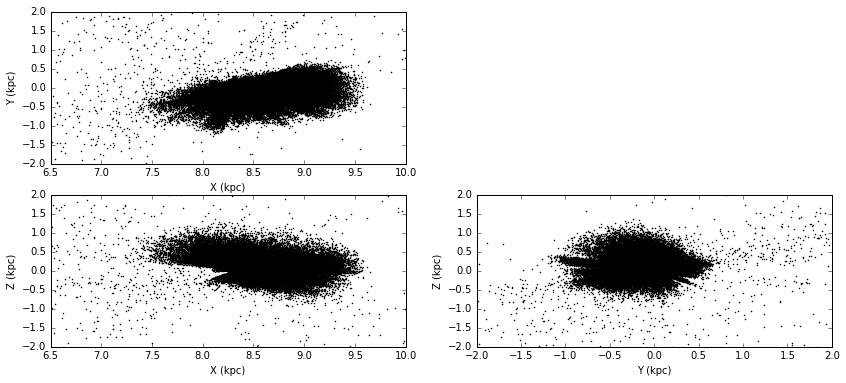

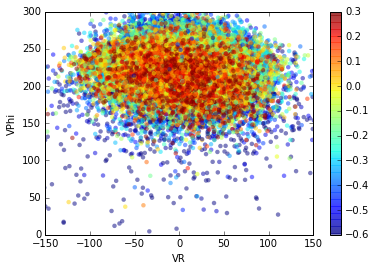

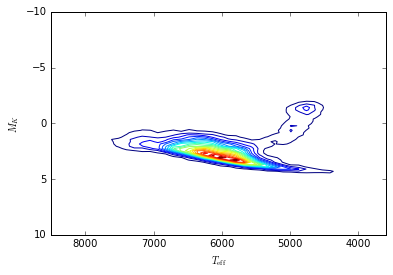

In [240]:
#data file is in dropbox with link: https://www.dropbox.com/s/66uy7ipp0t3gbmp/LAMOST_DR3_TGAS.fits?dl=0
filename = '/Users/chaoliu/pyw/TGAS/LAMOST_DR3_TGAS.fits'
tgas = loadData(filename)
V0 = 238 #km/s
velsun1 = [9.58,10.52,7.01] #Tian et al. 2015
Rsun = 8340 #Reid 2014 in parsec
X,Y,Z = spatialCoords(tgas.l_tgas,tgas.b_tgas,tgas.dist_tgas)
R = np.sqrt(X**2+Y**2)
Phi = np.arctan(Y/X)
ind = tgas.dist_error_tgas<0.3
drawSpatialDist(X[ind],Y[ind],Z[ind])
U, V, W, Uerr, Verr, Werr,VR,VPHI,VRerr,VPHIerr,VZ,VZerr = velocity(tgas,V0,velsun1,Rsun)
ind = (tgas.dist_error_tgas<0.3) * (np.abs(Z)<300)
drawInplaneVelDist(VR[ind],VPHI[ind],tgas.feh[ind])
drawHRdiagram(tgas.teff[ind],tgas.MK_tgas[ind])

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less_equal


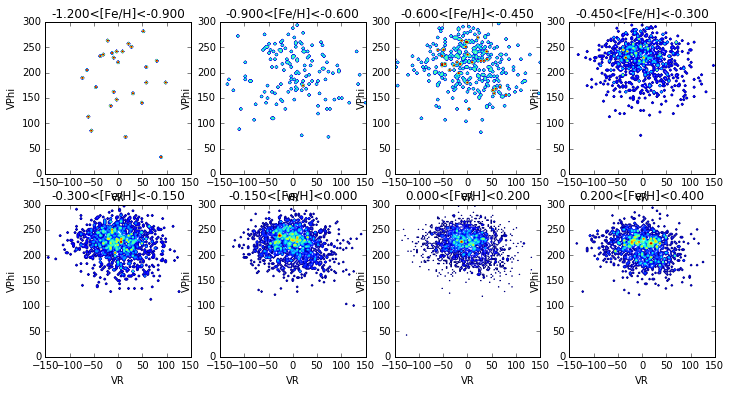

In [338]:
ind_K = (tgas.dist_error_tgas<0.3) * (tgas.teff>3500) * (tgas.teff<5700) *\
    (tgas.MK_tgas>-0.5) * (tgas.MK_tgas<3) * (np.abs(Z)<300)
ind0 = ind_K
fehgrid = np.array([-1.2,-0.9,-0.6,-0.45,-0.3,-0.15,0,0.2,0.4])
fehcenter = (fehgrid[0:len(fehgrid)-1]+fehgrid[1:len(fehgrid)])/2.0
VRgrid = np.linspace(-150,150,100)
VPhigrid = np.linspace(0,300,100)
fig = plt.figure(figsize=[12,6])
for i in xrange(len(fehcenter)):
    ind = ind0 * (tgas.feh>=fehgrid[i]) * (tgas.feh<=fehgrid[i+1])
    ax = fig.add_subplot(2,4,i+1)
    #sc = ax.scatter(VR[ind], VPHI[ind], c=tgas.feh[ind], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
    #ax.plot(VR[ind], VPHI[ind],'k.',markersize=2)
    mp,xgrid,ygrid = np.histogram2d(VR[ind], VPHI[ind],bins=[VRgrid,VPhigrid])
    ax.contour(mp.T,20,extent=[-150,150,0,300])
    ax.set_xlim([-150,150])
    ax.set_ylim([0,300])
    plt.title('%(a).3f<[Fe/H]<%(b).3f' % {'a':fehgrid[i],'b':fehgrid[i+1]})
    plt.xlabel('VR')
    plt.ylabel('VPhi')
fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less_equal


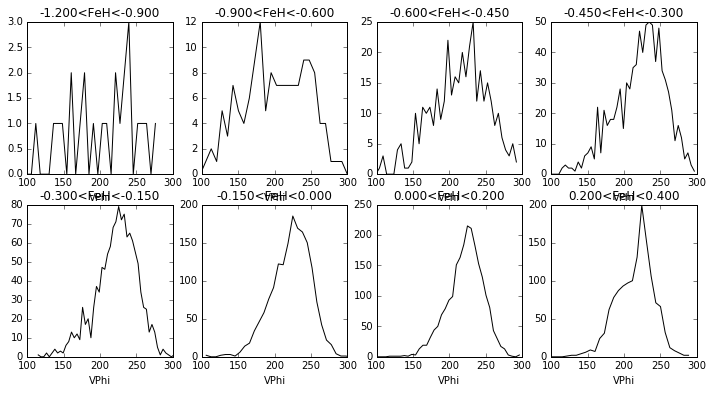

In [339]:

fig = plt.figure(figsize=[12,6])
for i in xrange(len(fehcenter)):
    ind = ind0 * (tgas.feh>=fehgrid[i]) * (tgas.feh<=fehgrid[i+1])
    ax = fig.add_subplot(2,4,i+1)
    mp,xgrid = np.histogram(VPHI[ind],bins=50)
    xcenter = (xgrid[0:len(xgrid)-1]+xgrid[1:len(xgrid)])/2.0
    ax.plot(xcenter,mp,'k-')
    ax.set_xlim([100,300])
    #ax.set_ylim([-150,150])
    plt.title('%(a).3f<FeH<%(b).3f' % {'a':fehgrid[i], 'b':fehgrid[i+1]})
    plt.xlabel('VPhi')
fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()


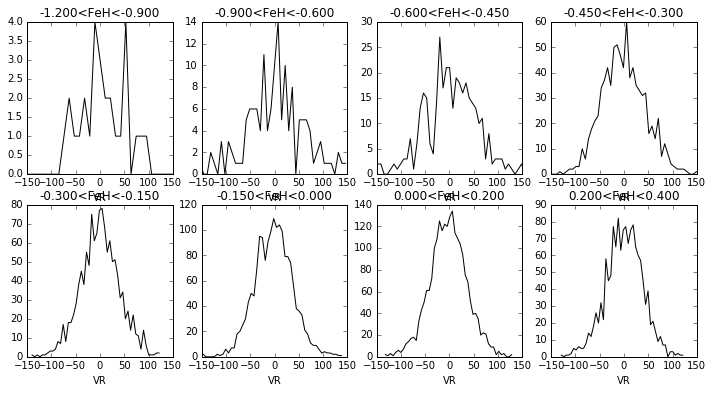

In [340]:
fig = plt.figure(figsize=[12,6])
for i in xrange(len(fehcenter)):
    ind = ind0 * (tgas.feh>=fehgrid[i]) * (tgas.feh<=fehgrid[i+1])
    ax = fig.add_subplot(2,4,i+1)
    mp,xgrid = np.histogram(VR[ind],bins=50)
    xcenter = (xgrid[0:len(xgrid)-1]+xgrid[1:len(xgrid)])/2.0
    ax.plot(xcenter,mp,'k-')
    ax.set_xlim([-150,150])
    #ax.set_ylim([-150,150])
    plt.title('%(a).3f<FeH<%(b).3f' % {'a':fehgrid[i], 'b':fehgrid[i+1]})
    plt.xlabel('VR')
fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in less_equal


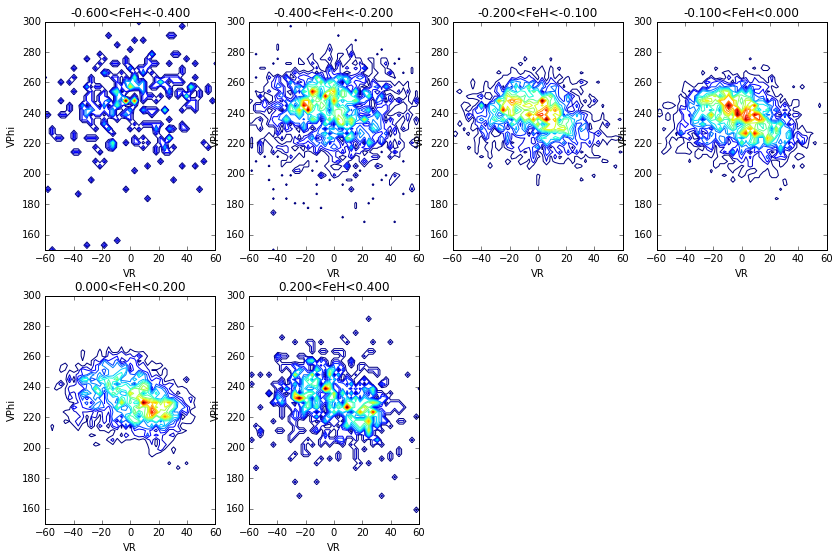

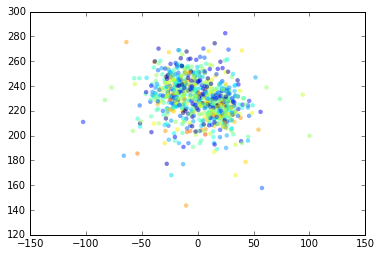

In [365]:
ind_F = (tgas.dist_error_tgas<0.3) * (tgas.teff>6500) * (tgas.teff<7500) *\
    (tgas.MK_tgas>-1) * (tgas.MK_tgas<3) * (np.abs(Z)<300)
ind0  = ind_F
fehgrid = np.array([-0.6,-0.4,-0.2,-0.1,0,0.2,0.4])
fehcenter = (fehgrid[0:len(fehgrid)-1]+fehgrid[1:len(fehgrid)])/2.0
VRgrid = np.linspace(-150,150,100)
VPhigrid = np.linspace(0,300,100)
fig = plt.figure(figsize=[14,9])
for i in xrange(len(fehcenter)):
    ind = ind0 * (tgas.feh>=fehgrid[i]) * (tgas.feh<=fehgrid[i+1])
    ax = fig.add_subplot(2,4,i+1)
    #sc = ax.scatter(VR[ind], VPHI[ind], c=tgas.feh[ind], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
    #ax.plot(VR[ind], VPHI[ind],'k.',markersize=2)
    mp,xgrid,ygrid = np.histogram2d(VR[ind], VPHI[ind],bins=[VRgrid,VPhigrid])
    ax.contour(mp.T,20,extent=[-150,150,0,300])
    ax.set_xlim([-60,60])
    ax.set_ylim([150,300])
    plt.title('%(a).3f<FeH<%(b).3f' % {'a':fehgrid[i], 'b':fehgrid[i+1]})
    plt.xlabel('VR')
    plt.ylabel('VPhi')

fig.show()
fig.savefig('VRVPhi_fehbins.png')
####
ind0 * (tgas.feh>=-0.6) * (tgas.feh<=-0.1)
fig = plt.figure()
ax = fig.add_subplot(111)
sc = ax.scatter(VR[ind], VPHI[ind], c=Phi[ind]*180.0/np.pi, alpha=0.5, vmin=-5, vmax=+5, edgecolors='none')

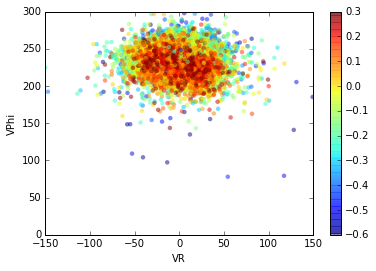

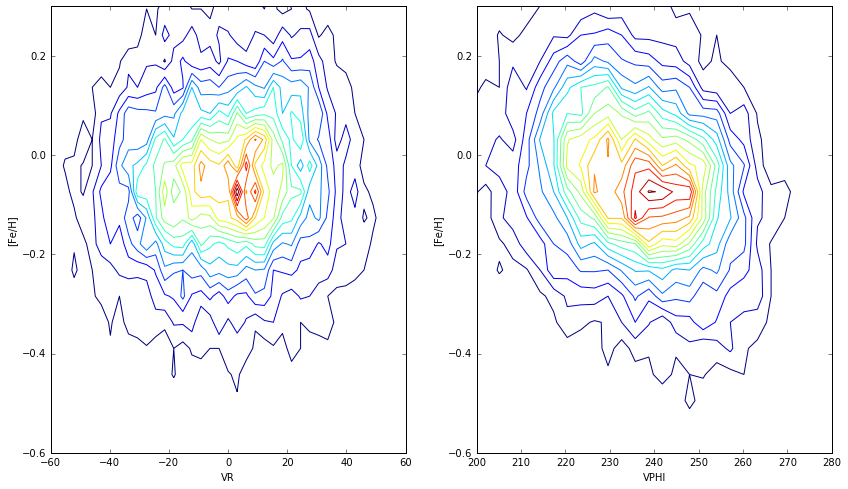

In [342]:
fig = plt.figure()
ax = fig.add_subplot(111)
sc = ax.scatter(VR[ind0], VPHI[ind0], c=tgas.feh[ind0], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
ax.set_xlim([-150,150])
ax.set_ylim([0,300])
plt.xlabel('VR')
plt.ylabel('VPhi')
fig.colorbar(sc)
fig.show()
####
fig = plt.figure(figsize=[14,8])
ax = fig.add_subplot(121)
#plot(VR[ind0],tgas.feh[ind0],'k.',markersize=1)
mp,xgrid,ygrid = np.histogram2d(VR[ind0], tgas.feh[ind0],bins=[VRgrid,np.linspace(-0.6,0.4,21)])
ax.contour(mp.T,20,extent=[-150,150,-0.6,0.4])
ax.set_xlim([-60,60])
ax.set_ylim([-0.6,0.3])
plt.xlabel('VR')
plt.ylabel('[Fe/H]')
fig.show()
ax = fig.add_subplot(122)
#plot(VR[ind0],tgas.feh[ind0],'k.',markersize=1)
mp,xgrid,ygrid = np.histogram2d(VPHI[ind0], tgas.feh[ind0],bins=[VPhigrid,np.linspace(-0.6,0.4,21)])
ax.contour(mp.T,20,extent=[0,300,-0.6,0.4])
ax.set_xlim([200,280])
ax.set_ylim([-0.6,0.3])
plt.xlabel('VPHI')
plt.ylabel('[Fe/H]')
fig.show()

fig.savefig('V_feh.png')

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()


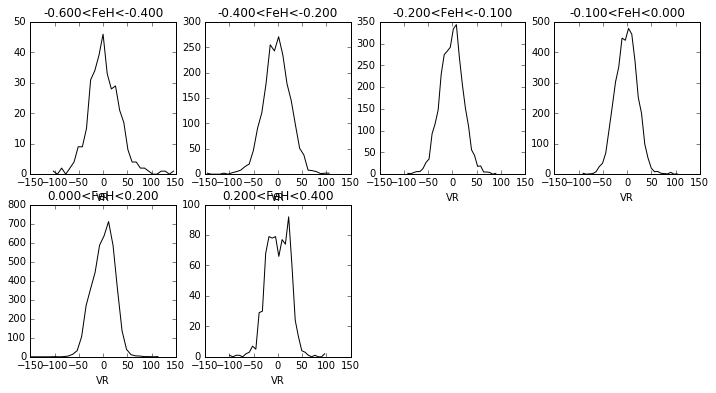

In [343]:
fig = plt.figure(figsize=[12,6])
for i in xrange(len(fehcenter)):
    ind = ind0 * (tgas.feh>=fehgrid[i]) * (tgas.feh<=fehgrid[i+1])
    ax = fig.add_subplot(2,4,i+1)
    mp,xgrid = np.histogram(VR[ind],bins=30)
    xcenter = (xgrid[0:len(xgrid)-1]+xgrid[1:len(xgrid)])/2.0
    ax.plot(xcenter,mp,'k-')
    ax.set_xlim([-150,150])
    #ax.set_ylim([-150,150])
    plt.title('%(a).3f<FeH<%(b).3f' % {'a':fehgrid[i], 'b':fehgrid[i+1]})
    plt.xlabel('VR')
fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


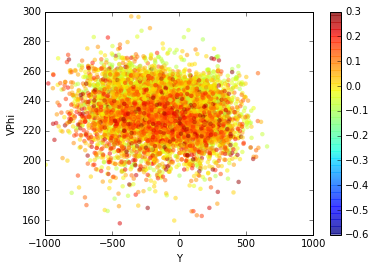

In [344]:
ind0 = (tgas.dist_error_tgas<0.3) * (tgas.teff>6500) * (tgas.teff<7500) *\
    (tgas.MK_tgas>-1) * (tgas.MK_tgas<3) * (np.abs(Z)<300) * (tgas.feh>-0.1) *\
    (tgas.feh<0.3)
fig = plt.figure()
ax = fig.add_subplot(111)
sc = ax.scatter(Y[ind0], VPHI[ind0], c=tgas.feh[ind0], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
ax.set_xlim([-1000,1000])
ax.set_ylim([150,300])
plt.xlabel('Y')
plt.ylabel('VPhi')
fig.colorbar(sc)
fig.show()
####

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in greater
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in greater
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning

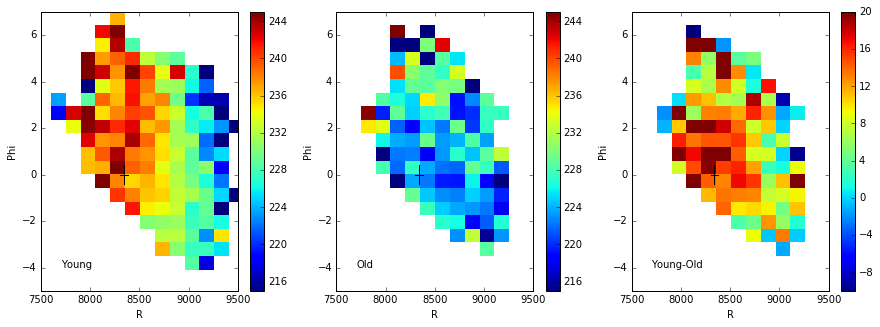

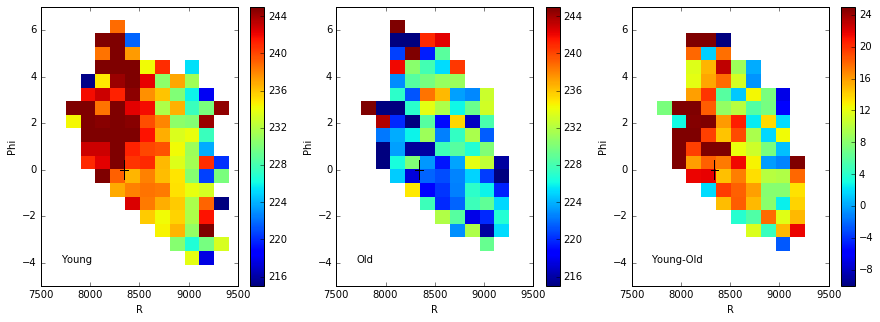

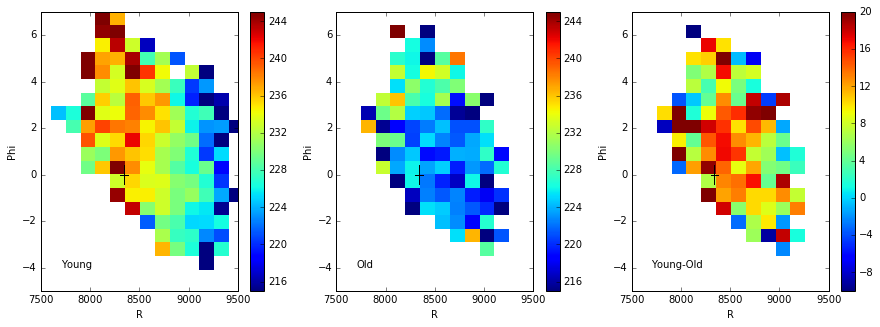

In [362]:
def drawRPhi(ax,mp,m1,m2, lab):
    #cc = ax.contourf(mp,20,extent=[7000,10000,-7,7],vmin=m1, vmax=m2)
    cc = ax.imshow(mp,extent=[7000,10000,7,-7],vmin=m1, vmax=m2,aspect='auto',interpolation='nearest')
    ax.plot([8300,8380],[0,0],'k-')
    ax.plot([8340,8340],[-0.4,0.4],'k-')
    ax.set_xlim([7500,9500])
    ax.set_ylim([-5,7])
    plt.colorbar(cc)
    #spiral from Reid14
    beta=np.linspace(-8.0,27.0,100)
    beta_ref=8.9
    Rref=8.4
    Psi=12.8*np.pi/180.0
    R=Rref*np.exp(-(beta-beta_ref)*np.tan(Psi)*np.pi/180)
    ax.plot((R-0.33)*1e3,beta,'k:',lineWidth=1)
    ax.plot((R)*1e3,beta,'k-',lineWidth=2)
    ax.plot((R+0.33)*1e3,beta,'k:',lineWidth=1)
    ax.text(7700,-4,lab)
    plt.xlabel('R')
    plt.ylabel('Phi')
####
Rgrid = np.linspace(7000,10000,21)
Pgrid = np.linspace(-7,7,25)
N=2
####
ind0 = ind_F * (tgas.feh>-0.6) * (tgas.feh<0.3)
ind1 = ind_K * (tgas.feh>-0.6) * (tgas.feh<0.3)
#ind0 = ind_F * VPHI>230
#ind1 = ind_K * VPHI>230
medianmap0 = median2d(R[ind0], -Phi[ind0]*180.0/np.pi, VPHI[ind0], Rgrid, Pgrid, N)
medianmap1 = median2d(R[ind1], -Phi[ind1]*180.0/np.pi, VPHI[ind1], Rgrid, Pgrid, N)
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(131)
drawRPhi(ax,medianmap0,215,245,'Young')
ax = fig.add_subplot(132)
drawRPhi(ax,medianmap1,215,245,'Old')
ax = fig.add_subplot(133)
drawRPhi(ax, medianmap0-medianmap1,-10,20,'Young-Old')
fig.show()

####
ind0p = ind_F * (tgas.feh>-0.6) *\
    (tgas.feh<-0.05)
ind1p = ind_K * (tgas.feh>-0.6) *\
    (tgas.feh<-0.05)
medianmap0p = median2d(R[ind0p], -Phi[ind0p]*180.0/np.pi, VPHI[ind0p], Rgrid, Pgrid, N)
medianmap1p = median2d(R[ind1p], -Phi[ind1p]*180.0/np.pi, VPHI[ind1p], Rgrid, Pgrid, N)
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(131)
drawRPhi(ax,medianmap0p,215,245,'Young')
ax = fig.add_subplot(132)
drawRPhi(ax,medianmap1p,215,245,'Old')
ax = fig.add_subplot(133)
drawRPhi(ax, medianmap0p-medianmap1p,-10,25,'Young-Old')
fig.show()
fig.savefig('Vphi_RPhi.png')
###
ind0m = ind_F * (tgas.feh>-0.1) *\
    (tgas.feh<1)
ind1m = ind_K * (tgas.feh>-0.1) *\
    (tgas.feh<1)
medianmap0m = median2d(R[ind0m], -Phi[ind0m]*180.0/np.pi, VPHI[ind0m], Rgrid, Pgrid, N)
medianmap1m = median2d(R[ind1m], -Phi[ind1m]*180.0/np.pi, VPHI[ind1m], Rgrid, Pgrid, N)
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(131)
drawRPhi(ax,medianmap0m,215,245,'Young')
ax = fig.add_subplot(132)
drawRPhi(ax,medianmap1m,215,245,'Old')
ax = fig.add_subplot(133)
drawRPhi(ax, medianmap0m-medianmap1m,-10,20,'Young-Old')

fig.show()

#fig.savefig('Vphi_RPhi.png')
#print medianmap

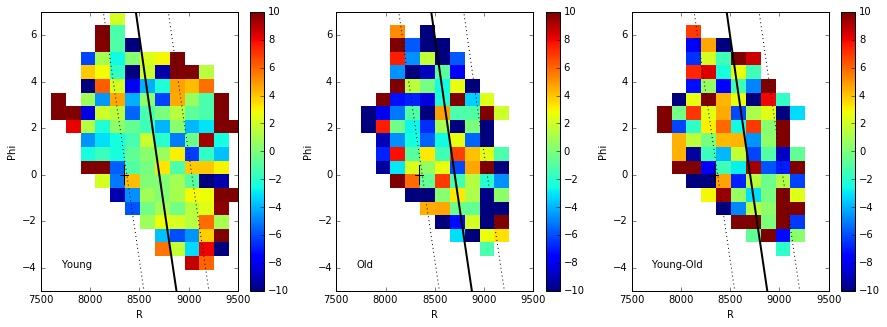

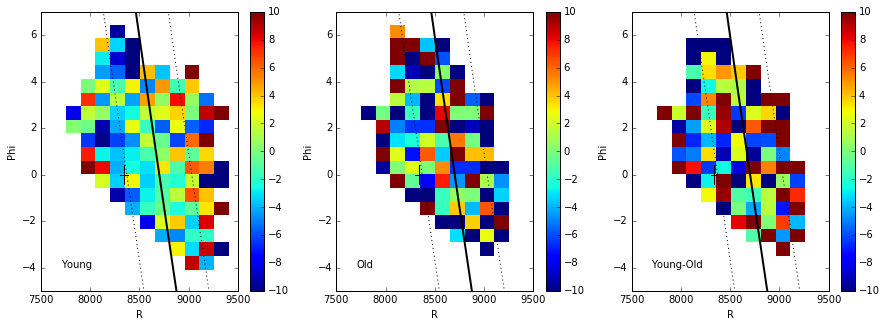

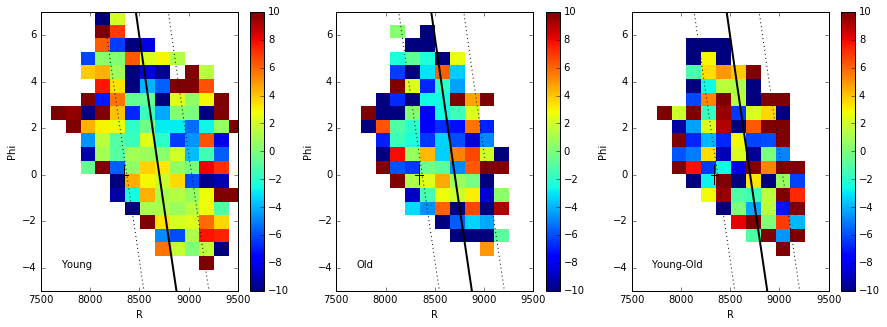

In [361]:

medianmap0 = median2d(R[ind0], -Phi[ind0]*180.0/np.pi, VR[ind0], Rgrid, Pgrid, N)
medianmap1 = median2d(R[ind1], -Phi[ind1]*180.0/np.pi, VR[ind1], Rgrid, Pgrid, N)
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(1,3,1)
drawRPhi(ax,medianmap0,-10,10,'Young')
ax = fig.add_subplot(1,3,2)
drawRPhi(ax,medianmap1,-10,10,'Old')
ax = fig.add_subplot(1,3,3)
drawRPhi(ax, medianmap0-medianmap1,-10,10,'Young-Old')
fig.show()

#####
medianmap0p = median2d(R[ind0p], -Phi[ind0p]*180.0/np.pi, VR[ind0p], Rgrid, Pgrid, N)
medianmap1p = median2d(R[ind1p], -Phi[ind1p]*180.0/np.pi, VR[ind1p], Rgrid, Pgrid, N)
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(1,3,1)
drawRPhi(ax,medianmap0p,-10,10,'Young')
ax = fig.add_subplot(1,3,2)
drawRPhi(ax,medianmap1p,-10,10,'Old')
ax = fig.add_subplot(1,3,3)
drawRPhi(ax, medianmap0p-medianmap1p,-10,10,'Young-Old')
fig.show()
fig.savefig('VR_RPhi.png')
#####
medianmap0m = median2d(R[ind0m], -Phi[ind0m]*180.0/np.pi, VR[ind0m], Rgrid, Pgrid, N)
medianmap1m = median2d(R[ind1m], -Phi[ind1m]*180.0/np.pi, VR[ind1m], Rgrid, Pgrid, N)
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(1,3,1)
drawRPhi(ax,medianmap0m,-10,10,'Young')
ax = fig.add_subplot(1,3,2)
drawRPhi(ax,medianmap1m,-10,10,'Old')
ax = fig.add_subplot(1,3,3)
drawRPhi(ax, medianmap0p-medianmap1p,-10,10,'Young-Old')
fig.show()

#fig.savefig('VR_RPhi.png')

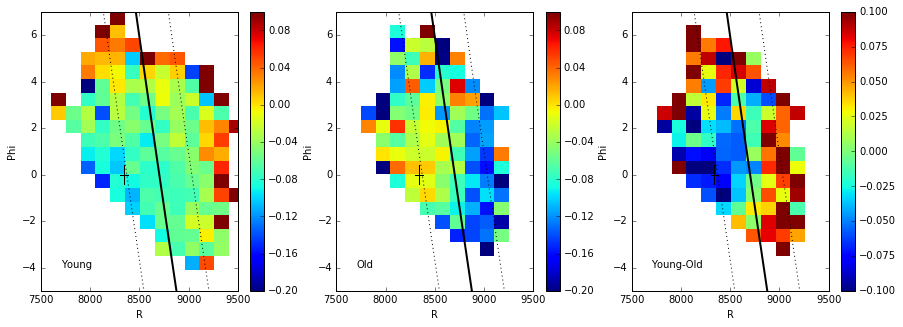

In [359]:
medianmap0 = median2d(R[ind0], -Phi[ind0]*180.0/np.pi, tgas.feh[ind0], Rgrid, Pgrid, N)
medianmap1 = median2d(R[ind1], -Phi[ind1]*180.0/np.pi, tgas.feh[ind1], Rgrid, Pgrid, N)
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(1,3,1)
drawRPhi(ax,medianmap0,-0.2,0.1,'Young')
ax = fig.add_subplot(1,3,2)
drawRPhi(ax,medianmap1,-0.2,0.1,'Old')
ax = fig.add_subplot(1,3,3)
drawRPhi(ax, medianmap0-medianmap1,-0.1,0.1,'Young-Old')

fig.show()
fig.savefig('FEH_RPhi.png')